In [1]:
# This notebook will contain only some NLP methods such as n-grams because the full notebook was getting too cumbersum.
# Data has been transformed in other notebook, we can just load it in here :)

In [2]:
# imports
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
# index_col stops index being read as column
df_turk = pd.read_csv('turk-Data-renamed.csv', index_col=0)
df_lab = pd.read_csv('lab-Data-renamed.csv', index_col=0)

In [4]:
df_turk

,button,event_type,target,time,x,y,step,turkId
0,1,mousedown,alloc-slider-1,0.000,477.0,405.0,1,A35YFAFWP33C70
1,1,mouseup,alloc-slider-1,0.111,478.0,405.0,1,A35YFAFWP33C70
2,1,click,alloc-slider-1,0.111,478.0,405.0,1,A35YFAFWP33C70
3,1,mousedown,alloc-slider-1,1.516,479.0,405.0,1,A35YFAFWP33C70
4,1,mousedirchange,alloc-slider-1,2.395,543.0,403.0,1,A35YFAFWP33C70
...,...,...,...,...,...,...,...,...
1293068,1,click,html,258.656,500.0,2198.0,1,A15781PHGW377Y
1293069,1,click,html,258.656,500.0,2198.0,2,A15781PHGW377Y
1293070,1,click,html,258.656,500.0,2198.0,3,A15781PHGW377Y
1293071,1,click,html,258.656,500.0,2198.0,4,A15781PHGW377Y


# Bag Of Words Models

Can treat each target as a word as use NLP methods such as bagofwords.
Will lose data regarding order but that can be analysed later with HMMs.

'In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity. The bag-of-words model has also been used for computer vision. - https://en.wikipedia.org/wiki/Bag-of-words_model'

disregarding grammer means nothing with this specific dataset


# Here they suggest bayes filtering can be used to detect language, maybe I use too?
https://stackoverflow.com/questions/101569/algorithm-to-detect-similar-documents-in-python-script

# Naive Bayes
Another idea from SPAM detection is using a naive bayes, here they get the count of each word for each email and bayes it.
Could even use this to get the counts of 2/3-grams to compare?
https://towardsdatascience.com/spam-filtering-using-naive-bayes-98a341224038

TODO: I think for any of these to be used we would have to properly rename all the mouse items so they match

In [5]:
# Another idea from SPAM detection is using a naive bayes, here they get the count of each word for each email and bayes it.
# Could even use this to get the counts of 2/3-grams to compare?
# https://towardsdatascience.com/spam-filtering-using-naive-bayes-98a341224038

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score



In [6]:
# Converts a pandas datafram of targets to a list of strings
def targets_to_string(dataframe):
    IDs = dataframe['turkId'].unique()
    targets_text = []

    for ID in IDs:
        targets_series = dataframe[ dataframe['turkId'] == ID ] ['target']
        targets =  ','.join(targets_series)
        targets_text.append( targets)
        #targets_text = targets

    return targets_text

turk_targets = targets_to_string(df_turk)
lab_targets = targets_to_string(df_lab)
turk_labels = np.zeros( len(turk_targets) )
lab_labels = np.ones( len(lab_targets) )


In [7]:

X = np.append(turk_targets, lab_targets)
y = np.append(turk_labels, lab_labels)


In [8]:

# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [9]:
#Explore CountVecotrizer

vectorizer = CountVectorizer(token_pattern='(.*?,)') 
counts = vectorizer.fit_transform(X_train)
p = counts.toarray()
p   
# Normally with Bag-Of-Words models we end up with a spare matrix of mainly 0s. https://machinelearningmastery.com/gentle-introduction-bag-words-model/
# However becuase our vocabulary is so limited (only 6 'words') the martix is full and so we dont have to wory about effeciency.
# TF-IDF will not work due to small vocabulary.
# Word hashing is used to help complexity but this is simple enough that we dont need it.

# Limitations of bag of words are - need a carefuly designed vocabulary - Matrix can get very sparse - Context lost.
# First 2 limitations dont apply to this data, last limitation is very relevant tho because we can imagine a user switching between sliders will have interesting order of targets that could be used in a model.

array([[ 163,  137,  182,  161,  206,   77],
       [  11,  448,  168,  152,  855, 1497],
       [ 185,   47,   55,  163,  452, 1506],
       ...,
       [ 198,  237,  267,  399,  435,  941],
       [ 359,  963,  255,  490,  747, 3095],
       [ 382,  839,  224,  288,  243,   80]], dtype=int64)

In [10]:
print(vectorizer.get_feature_names()) # Not sure if this worked correclty, lets try anyway lol.

['alloc-slider-1,', 'alloc-slider-2,', 'alloc-slider-3,', 'alloc-slider-4,', 'alloc-slider-5,', 'html,']


In [11]:
# Instantiating Multinomial Naive Bayes Classifier
classifier = MultinomialNB()
targets = y_train
classifier.fit(counts, targets)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [12]:
example_count = vectorizer.transform(X_test)
predictions = classifier.predict(example_count)
predictions

array([1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0.,
       1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
       1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.])

In [13]:
from sklearn.metrics import accuracy_score

print( accuracy_score(y_test, predictions) )

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)



0.4158415841584158


array([[37, 57],
       [ 2,  5]], dtype=int64)

Accuracy score: 0.4158415841584158
F1 score: 0.3506592568377465
[[37 57]
 [ 2  5]]


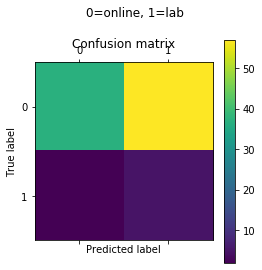

In [14]:

print( f'Accuracy score: {accuracy_score(y_test, predictions)}' )
f1 = f1_score(y_test, predictions, average='macro')
print( f'F1 score: {f1}' )

# High accuracy because of imbalenced classes 
# https://machinelearningmastery.com/failure-of-accuracy-for-imbalanced-class-distributions/
# This website has some nice references about imblaenced class distributions. TODO: use in diss.
# data sampling – customized algorithms– cost sensitive algorithms– one class algorithms – threshold moving – probability calibration


# https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/
# Better ways of dealing with imbalenced data

cm = confusion_matrix(y_test, predictions)
print(cm)

plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [15]:
# Above has too much online data so there are uneven classes.
# Look at only the first X (20 or so) online data for training

#X_train, X_test, y_train, y_test = train_test_split(X, y)

# TODO: make classes balenced

lab_length = len(lab_targets)

X_balanced = np.append( turk_targets[ :lab_length ] , lab_targets)

y_balanced = np.append(turk_labels[ :lab_length ], lab_labels)

print(f'Length of lab and turk data: {len(X_balanced)}')

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced)

vectorizer = CountVectorizer(token_pattern='(.*?,)') 
counts = vectorizer.fit_transform(X_train)

classifier = MultinomialNB()
targets = y_train
classifier.fit(counts, targets)

example_count = vectorizer.transform(X_test)
predictions = classifier.predict(example_count)

print( f'Accuracy score: {accuracy_score(y_test, predictions)}' )
f1 = f1_score(y_test, predictions, average='macro')
print( f'F1 score: {f1}' )
cm = confusion_matrix(y_test, predictions)
print(cm)


Length of lab and turk data: 28
Accuracy score: 0.5714285714285714
F1 score: 0.5714285714285715
[[2 3]
 [0 2]]


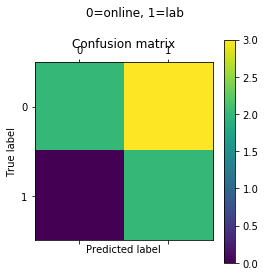

In [16]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Accuracy score: 1.0
F1 score: 1.0
[[5 0]
 [0 2]]


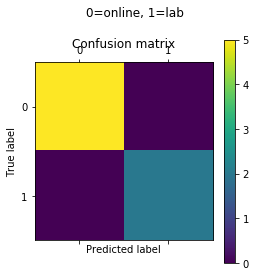

In [17]:
# Try a different method of Spam classification
# https://towardsdatascience.com/spam-detection-with-logistic-regression-23e3709e522


from sklearn.linear_model import LogisticRegression

######################
# Even class sizes

Spam_model = LogisticRegression(solver='liblinear', penalty='l1')
Spam_model.fit(counts, y_train)

example_count = vectorizer.transform(X_test)
pred = Spam_model.predict(example_count)
print( f'Accuracy score: {accuracy_score(y_test,pred)}' )
f1 = f1_score(y_test, pred, average='macro')
print( f'F1 score: {f1}' )
# Accuracy of 0.66% not the best but also not bad.
# TODO: Run this on bi/tri-grams data to see if that will be better.
# Instead of having a matrix of the differnt words, have matrix of different ngrams.

cm = confusion_matrix(y_test, pred)
print(cm)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


Accuracy score: 0.9603960396039604
F1 score: 0.4898989898989899
[[97  0]
 [ 4  0]]


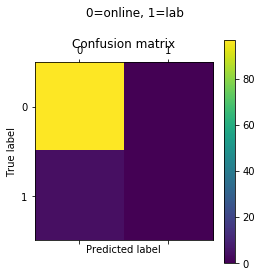

In [18]:
# Try Logistical regression with unbalanced classes.
#https://machinelearningmastery.com/what-is-imbalanced-classification/

# X, y are still the full dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y)

vectorizer = CountVectorizer(token_pattern='(.*?,)') 
counts = vectorizer.fit_transform(X_train)

Spam_model = LogisticRegression(solver='liblinear', penalty='l1')
Spam_model.fit(counts, y_train)

example_count = vectorizer.transform(X_test)
pred = Spam_model.predict(example_count)
print( f'Accuracy score: {accuracy_score(y_test,pred)}' )
f1 = f1_score(y_test, pred, average='macro')
print( f'F1 score: {f1}' )
# Accuracy of 0.66% not the best but also not bad.
# TODO: Run this on bi/tri-grams data to see if that will be better.
# Instead of having a matrix of the differnt words, have matrix of different ngrams.

cm = confusion_matrix(y_test, pred)
print(cm)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# N-Gram data rather than target count data

The algorithms used above are just using the mouse target variables to varying success.
Try similar approaches to the balanced methods, but use bi/tri-gram data rather than just none/unigrams.



In [19]:
# TODO get a list of bi grams for each user.
# Turns out the Count Vectorizer has an ngram feature :/

# First do with unbalanced classes, then balanced.
X_train, X_test, y_train, y_test = train_test_split(X, y)

vectorizer_ngram = CountVectorizer(token_pattern='(.*?,)', ngram_range=(2, 2))
ngram_counts = vectorizer_ngram.fit_transform(X_train)
print(vectorizer_ngram.get_feature_names()) # Not sure if this worked correclty, lets try anyway lol.

X_test = vectorizer_ngram.transform(X_test) # TODO: SHould be treating alloc-slider-1/alloc-slider-2 as different n-grams.


['alloc-slider-1, alloc-slider-1,', 'alloc-slider-1, alloc-slider-2,', 'alloc-slider-1, alloc-slider-3,', 'alloc-slider-1, alloc-slider-4,', 'alloc-slider-1, alloc-slider-5,', 'alloc-slider-1, html,', 'alloc-slider-2, alloc-slider-1,', 'alloc-slider-2, alloc-slider-2,', 'alloc-slider-2, alloc-slider-3,', 'alloc-slider-2, alloc-slider-4,', 'alloc-slider-2, alloc-slider-5,', 'alloc-slider-2, html,', 'alloc-slider-3, alloc-slider-1,', 'alloc-slider-3, alloc-slider-2,', 'alloc-slider-3, alloc-slider-3,', 'alloc-slider-3, alloc-slider-4,', 'alloc-slider-3, alloc-slider-5,', 'alloc-slider-3, html,', 'alloc-slider-4, alloc-slider-1,', 'alloc-slider-4, alloc-slider-2,', 'alloc-slider-4, alloc-slider-3,', 'alloc-slider-4, alloc-slider-4,', 'alloc-slider-4, alloc-slider-5,', 'alloc-slider-4, html,', 'alloc-slider-5, alloc-slider-1,', 'alloc-slider-5, alloc-slider-2,', 'alloc-slider-5, alloc-slider-3,', 'alloc-slider-5, alloc-slider-4,', 'alloc-slider-5, alloc-slider-5,', 'alloc-slider-5, html,',

Accuracy score: 0.9306930693069307
F1 score: 0.5929763960852044
[[93  4]
 [ 3  1]]


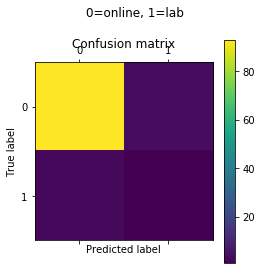

In [20]:

Spam_model = LogisticRegression(solver='liblinear', penalty='l1')
Spam_model.fit(ngram_counts, y_train)

pred = Spam_model.predict(X_test)
print( f'Accuracy score: {accuracy_score(y_test, pred)}' )
f1 = f1_score(y_test, pred, average='macro')
print( f'F1 score: {f1}' )
# Accuracy of 0.96 on unbalanced data

cm = confusion_matrix(y_test, pred)
print(cm)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

['alloc-slider-1, alloc-slider-1,', 'alloc-slider-1, alloc-slider-2,', 'alloc-slider-1, alloc-slider-3,', 'alloc-slider-1, alloc-slider-4,', 'alloc-slider-1, alloc-slider-5,', 'alloc-slider-1, html,', 'alloc-slider-2, alloc-slider-1,', 'alloc-slider-2, alloc-slider-2,', 'alloc-slider-2, alloc-slider-3,', 'alloc-slider-2, alloc-slider-4,', 'alloc-slider-2, alloc-slider-5,', 'alloc-slider-2, html,', 'alloc-slider-3, alloc-slider-1,', 'alloc-slider-3, alloc-slider-2,', 'alloc-slider-3, alloc-slider-3,', 'alloc-slider-3, alloc-slider-4,', 'alloc-slider-3, alloc-slider-5,', 'alloc-slider-3, html,', 'alloc-slider-4, alloc-slider-1,', 'alloc-slider-4, alloc-slider-2,', 'alloc-slider-4, alloc-slider-3,', 'alloc-slider-4, alloc-slider-4,', 'alloc-slider-4, alloc-slider-5,', 'alloc-slider-4, html,', 'alloc-slider-5, alloc-slider-1,', 'alloc-slider-5, alloc-slider-2,', 'alloc-slider-5, alloc-slider-3,', 'alloc-slider-5, alloc-slider-4,', 'alloc-slider-5, alloc-slider-5,', 'alloc-slider-5, html,',

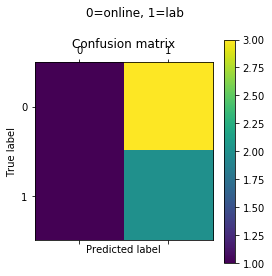

In [21]:
# Try with n-grams and balanced data.

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced)

vectorizer_ngram = CountVectorizer(token_pattern='(.*?,)', ngram_range=(2, 2))
ngram_counts = vectorizer_ngram.fit_transform(X_train)
print(vectorizer_ngram.get_feature_names()) # Not sure if this worked correclty, lets try anyway lol.

X_test = vectorizer_ngram.transform(X_test)

Spam_model = LogisticRegression(solver='liblinear', penalty='l1')
Spam_model.fit(ngram_counts, y_train)

pred = Spam_model.predict(X_test)
print( f'\nAccuracy score: {accuracy_score(y_test, pred)}' )
f1 = f1_score(y_test, pred, average='macro')
print( f'F1 score: {f1}' )
# Accuracy of 0.777 on balanced data
# Prety good, I imagine if this was working proberly itd be even better


cm = confusion_matrix(y_train, Spam_model.predict(ngram_counts))
print('Train data matrix: \n', cm)
cm = confusion_matrix(y_test, pred)
print('Test data matrix: \n', cm)

plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


['alloc-slider-1, alloc-slider-1, alloc-slider-1,', 'alloc-slider-1, alloc-slider-1, alloc-slider-2,', 'alloc-slider-1, alloc-slider-1, alloc-slider-3,', 'alloc-slider-1, alloc-slider-1, alloc-slider-4,', 'alloc-slider-1, alloc-slider-1, alloc-slider-5,', 'alloc-slider-1, alloc-slider-1, html,', 'alloc-slider-1, alloc-slider-2, alloc-slider-1,', 'alloc-slider-1, alloc-slider-2, alloc-slider-2,', 'alloc-slider-1, alloc-slider-2, alloc-slider-3,', 'alloc-slider-1, alloc-slider-2, html,']

Accuracy score: 0.42857142857142855
F1 score: 0.41666666666666663
Train data matrix: 
 [[10  0]
 [ 0 11]]
Test data matrix: 
 [[1 3]
 [1 2]]


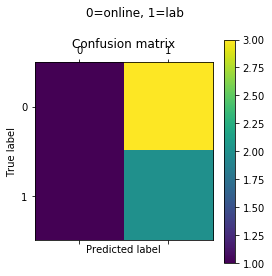

In [22]:
# BALENCED TRIGRAMS

# Try with n-grams and balanced data.

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced)

vectorizer_ngram = CountVectorizer(token_pattern='(.*?,)', ngram_range=(3, 3))
ngram_counts = vectorizer_ngram.fit_transform(X_train)
print(vectorizer_ngram.get_feature_names()[:10]) # Not sure if this worked correclty, lets try anyway lol.

X_test = vectorizer_ngram.transform(X_test)

Spam_model = LogisticRegression(solver='liblinear', penalty='l1')
Spam_model.fit(ngram_counts, y_train)

pred = Spam_model.predict(X_test)
print( f'\nAccuracy score: {accuracy_score(y_test, pred)}' )
f1 = f1_score(y_test, pred, average='macro')
print( f'F1 score: {f1}' )
# Accuracy of 0.777 on balanced data
# Prety good, I imagine if this was working proberly itd be even better


cm = confusion_matrix(y_train, Spam_model.predict(ngram_counts))
print('Train data matrix: \n', cm)
cm = confusion_matrix(y_test, pred)
print('Test data matrix: \n', cm)

plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


['alloc-slider-1,', 'alloc-slider-1, alloc-slider-1,', 'alloc-slider-1, alloc-slider-2,', 'alloc-slider-1, alloc-slider-3,', 'alloc-slider-1, alloc-slider-4,', 'alloc-slider-1, alloc-slider-5,', 'alloc-slider-1, html,', 'alloc-slider-2,', 'alloc-slider-2, alloc-slider-1,', 'alloc-slider-2, alloc-slider-2,']

Accuracy score: 0.7142857142857143
F1 score: 0.7083333333333333
Train data matrix: 
 [[11  0]
 [ 0 10]]
Test data matrix: 
 [[3 0]
 [2 2]]


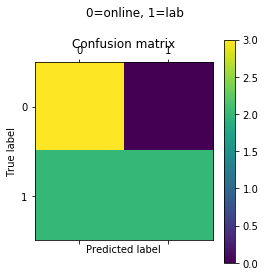

In [23]:
# BALENCED UNI and BiGRAMS

# Try with n-grams and balanced data.

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced)

vectorizer_ngram = CountVectorizer(token_pattern='(.*?,)', ngram_range=(1, 2))
ngram_counts = vectorizer_ngram.fit_transform(X_train)
print(vectorizer_ngram.get_feature_names()[:10]) # Not sure if this worked correclty, lets try anyway lol.

X_test = vectorizer_ngram.transform(X_test)

Spam_model = LogisticRegression(solver='liblinear', penalty='l1')
Spam_model.fit(ngram_counts, y_train)

pred = Spam_model.predict(X_test)
print( f'\nAccuracy score: {accuracy_score(y_test, pred)}' )
f1 = f1_score(y_test, pred, average='macro')
print( f'F1 score: {f1}' )
# Accuracy of 0.777 on balanced data
# Prety good, I imagine if this was working proberly itd be even better


cm = confusion_matrix(y_train, Spam_model.predict(ngram_counts))
print('Train data matrix: \n', cm)
cm = confusion_matrix(y_test, pred)
print('Test data matrix: \n', cm)

plt.matshow(cm)
plt.title('Confusion matrix')
plt.suptitle('0=online, 1=lab')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# Try HMM

Not entirely sure how these work but will word it out as I go along.


https://towardsdatascience.com/hidden-markov-models-for-time-series-classification-basic-overview-a59b74e5e65b
    Normally towardsdatascience is really good but this makes no sense to me at all.

This article is more complicated, but also indepth and explains stuff more. - https://towardsdatascience.com/markov-chains-and-hmms-ceaf2c854788

Some guys github repository using HMM for binary sentimental analysis of tweets - https://github.com/FantacherJOY/Hidden-Markov-Model-for-NLP


"In the case one label is way more frequent than the other (say Class B appears for every 100 samples of Class A), or in the case one category is broader than the other (have more variance, i.e. Class A is an expected behavior of a process and Class B is all the cases that are abnormal), then we might want to train a unique HMM for Class A. For each new sample, we compute the likelihood to the model, and if it falls below a pre-defined threshold (that can be chosen with respect to some validation sample, or in the worst case, from the training samples themselves) we assign this sample to Class B. If the likelihood is above the threshold, we assign the sample to Class A." - https://datascience.stackexchange.com/questions/8560/can-hmm-be-used-as-a-binary-classifier

In [24]:
# https://hmmlearn.readthedocs.io/en/latest/tutorial.html
# experimenting with the Working with multiple sequences part.]

#https://stackoverflow.com/questions/52515134/hmmlearn-classification-usage

from hmmlearn import hmm

X1 = [[0.5], [1.0], [-1.0], [0.42], [0.24]]
X2 = [[2.4], [4.2], [0.5], [-0.24]]
X = np.concatenate([X1, X2]) # X = 1D array of length 9
lengths = [len(X1), len(X2)] # lengths = [5,4], array of length 2

In [25]:
model = hmm.GaussianHMM(n_components=3).fit(X, lengths)
model

Fitting a model with 14 free scalar parameters with only 9 data points will result in a degenerate solution.


GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=3, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [26]:
# 'The HMM is a generative probabilistic model, in which 
# a sequence of observable X variables is generated by a sequence of internal hidden states Z.
# The hidden states are not observed directly.'

X, Z = model.sample(10)

In [27]:
X, Z

(array([[ 1.83290467],
        [ 0.44677971],
        [ 0.07481496],
        [ 0.59689872],
        [-0.06837552],
        [-0.36102965],
        [ 0.25129207],
        [ 0.48099482],
        [ 0.05022739],
        [-0.01714811]]),
 array([0, 2, 1, 2, 1, 1, 2, 2, 1, 1]))

In [82]:
# Attempt with some trial user data
#X1 = [['Slider-1'], ['Slider-2'], ['Slider-2'], ['Slider-3'], ['Slider-3']]
#X2 = [['Slider-1'], ['Slider-2'], ['Slider-2'], ['Slider-1']]
X1 = [[1], [2], [2], [3], [3]]
X2 = [[1], [2], [2], [3]]
X = np.concatenate([X1, X2]) # X = 1D array of length 9
lengths = [len(X1), len(X2)] # lengths = [5,4], array of length 2

model = hmm.GaussianHMM(n_components=3).fit(X, lengths)

model.sample(5)

Fitting a model with 14 free scalar parameters with only 9 data points will result in a degenerate solution.


(array([[0.95610629],
        [2.03009789],
        [1.98543305],
        [2.04651359],
        [1.94539097]]),
 array([0, 1, 1, 1, 1]))

In [83]:
model.predict([[1], [2], [2], [3]]) # Think this is predicting the hidden states, given a sequence of numbers.

array([0, 1, 1, 2])

In [84]:
#Returns:	posteriors – State-membership probabilities for each sample from X

model.predict_proba([[1], [2], [2], [3]])   # Compute the posterior probability for each state in the model.
                                            # Think this array is read: states are the 3 columns. col0=state0, col1=state1, col2=state2
                                            # Rows are the input items. row0=input0=[1], row1=input1=[2], row3=input2=[2], row3=input2=[3]

array([[1.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [1.10144554e-257, 1.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 1.00000000e+000, 1.24276308e-065],
       [0.00000000e+000, 1.59798606e-087, 1.00000000e+000]])

In [85]:
# Look into model score
# https://stackoverflow.com/questions/52515134/hmmlearn-classification-usage
# This provides a good overview of how to train a hmm for binary classification.

# Compute the log probability under the model. # TODO find out what log probability is

print( model.score([[1], [2], [2], [3]]) )  # This sequence was in training data so high score expected.
print( model.score([[1], [2], [3]]) )       # This sequence is shorter than the training data but no new items so high score expected again.
print( model.score([[1], [1], [2], [3]]) )  # Similar sequence, but no training data has [1], [1]
print( model.score([[0], [1], [2], [3]]) )  # Similar sequence but new item 0 which hasnt been seen before.

6.430465973771518
5.046819413982146
-193.56953402622844
-293.5695340262285


In [86]:
#Compute the log probability under the model and compute posteriors.
model.score_samples([[1], [2], [2], [3]])   # Just does what predict_proba and score but together.

(6.430465973771518,
 array([[1.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        [1.10144554e-257, 1.00000000e+000, 0.00000000e+000],
        [0.00000000e+000, 1.00000000e+000, 1.24276308e-065],
        [0.00000000e+000, 1.59798606e-087, 1.00000000e+000]]))

In [87]:
model._compute_log_likelihood( np.array([[1], [2], [2], [3]]) ) # Not too sure what this is caluclating.

array([[   1.73022015, -197.92320626, -598.0670473 ],
       [ -98.26977985,    2.07679374, -148.0670473 ],
       [ -98.26977985,    2.07679374, -148.0670473 ],
       [-398.26977985, -197.92320626,    1.9329527 ]])

In [89]:
# Matrix of transition probabilities between states.
# This could be calculated from the n-grams but it might be correct here

transmat = model.transmat_
transmat

array([[2.09361211e-214, 1.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 5.00000000e-001, 5.00000000e-001],
       [0.00000000e+000, 4.90231332e-242, 1.00000000e+000]])

# Data Engineering

Initial exploration shown to be promising.
Now do some data engineering to get the targets into the format I want.

In [33]:
# First get the targets data in a time series of time, target, and ID.

# When we remove the mouse event we have much more duplicate data.
# Drop this data and reset the indexes to account for missing values.
# Since there was a correlation between time and number of mouse events maybe I can use index to substitue for time.

df_m_lab = df_lab[['target', 'time', 'turkId']]     # m for markov
lab_dups = len(df_m_lab)-len(df_m_lab.drop_duplicates())
print(f'Number of duplicate items in lab data: {lab_dups}')
print(f'Percentage duplicate: {lab_dups / len(df_lab) * 100}\n')
df_m_lab = df_m_lab.drop_duplicates()

df_m_turk = df_turk[['target', 'time', 'turkId']]
turk_dups = len(df_m_turk)-len(df_m_turk.drop_duplicates())
print(f'Number of duplicate items in turk data: {turk_dups}')
print(f'Percentage duplicate: {turk_dups / len(df_m_turk) * 100}')
df_m_turk = df_m_turk.drop_duplicates()

df_m_lab

Number of duplicate items in lab data: 9482
Percentage duplicate: 25.309630578688875

Number of duplicate items in turk data: 180378
Percentage duplicate: 21.656231428176945


,target,time,turkId
0,alloc-slider-5,0.000000,ID1
1,alloc-slider-5,0.547000,ID1
3,alloc-slider-5,1.176995,ID1
4,alloc-slider-5,1.790000,ID1
5,html,2.896995,ID1
...,...,...,...
58261,alloc-slider-2,273.796495,ID18
58263,alloc-slider-2,273.836415,ID18
58265,alloc-slider-2,273.924560,ID18
58270,html,274.968440,ID18


In [34]:
# TODO: Might have to convert targets to numerical representation, maybe one-hot encoding?

In [35]:
# Replace html with 0, and alloc-slider-1 to 1, alloc-slider-2 to 2, alloc-slider-3 to 3, alloc-slider-4 to 4, alloc-slider-5 to 5

df_m_lab.loc[df_m_lab['target'].str.contains('html'), 'target'] = '0'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-1'), 'target'] = '1'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-2'), 'target'] = '2'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-3'), 'target'] = '3'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-4'), 'target'] = '4'
df_m_lab.loc[df_m_lab['target'].str.contains('alloc-slider-5'), 'target'] = '5'
m_lab = df_m_lab['target'].to_numpy().reshape(-1, 1)

df_m_turk.loc[df_m_turk['target'].str.contains('html'), 'target'] = '0'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-1'), 'target'] = '1'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-2'), 'target'] = '2'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-3'), 'target'] = '3'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-4'), 'target'] = '4'
df_m_turk.loc[df_m_turk['target'].str.contains('alloc-slider-5'), 'target'] = '5'
m_turk = df_m_turk['target'].astype('int32').to_numpy().reshape(-1, 1)

In [36]:
m_turk.shape

(652537, 1)

In [37]:
# we want to have everything in one long array like this.
# But then we need to create the lengths array thing.

lab_lengths = []
for ID in df_m_lab['turkId'].unique():
    length_for_ID = len( df_m_lab[df_m_lab['turkId'] == ID] )
    lab_lengths.append(length_for_ID)

turk_lengths = []
for ID in df_m_turk['turkId'].unique():
    length_for_ID = len( df_m_turk[df_m_turk['turkId'] == ID] )
    turk_lengths.append(length_for_ID)

lab_lengths

[2267,
 2341,
 2341,
 646,
 597,
 3116,
 1531,
 490,
 2666,
 469,
 3754,
 3754,
 2005,
 2005]

In [90]:
# Create Lab data HMM

# Suggestions for number of hidden states.
# https://www.researchgate.net/post/Is_there_any_simple_rule_for_the_number_of_states_in_HMM

lab_model = hmm.GaussianHMM(n_components=6).fit(m_lab, lab_lengths) # dont know how many components/hidden states I should have
lab_model

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=6, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [92]:
lab_model.sample(10)

(array([[1.00272694],
        [0.99982411],
        [2.99781275],
        [2.99973058],
        [3.00193175],
        [3.00191847],
        [2.99955899],
        [3.00061814],
        [3.00005541],
        [3.00151366]]),
 array([0, 0, 3, 3, 3, 3, 3, 3, 3, 3]))

In [101]:
# Lab Transition Matrix
np.round(lab_model.transmat_, 3)

array([[0.941, 0.003, 0.027, 0.007, 0.005, 0.017],
       [0.001, 0.953, 0.002, 0.012, 0.019, 0.014],
       [0.015, 0.002, 0.948, 0.02 , 0.004, 0.012],
       [0.005, 0.019, 0.018, 0.942, 0.005, 0.011],
       [0.005, 0.021, 0.006, 0.005, 0.948, 0.015],
       [0.025, 0.015, 0.013, 0.015, 0.018, 0.913]])

In [41]:
turk_model = hmm.GaussianHMM(n_components=6).fit(m_turk.reshape(-1, 1), turk_lengths) # dont know how many components/hidden states I should have
turk_model

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=6, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [107]:
np.round(turk_model.transmat_, 2)

array([[0.93, 0.03, 0.  , 0.01, 0.02, 0.  ],
       [0.02, 0.93, 0.01, 0.02, 0.02, 0.01],
       [0.  , 0.02, 0.95, 0.  , 0.01, 0.  ],
       [0.01, 0.02, 0.  , 0.95, 0.  , 0.01],
       [0.01, 0.02, 0.02, 0.01, 0.94, 0.  ],
       [0.  , 0.02, 0.  , 0.02, 0.  , 0.95]])

In [123]:
np.round(np.array(turk_model.sample(10)[0]).reshape(-1),2)

#turk_model.sample(10)

array([-0., -0., -0.,  0.,  4.,  4.,  4.,  4.,  3.,  3.])

In [43]:
#for i in range(len(lab_lengths)):
#    print( turk_model.score( m_lab[i].reshape(-1, 1) ) )

# Have to have all this extra code because the data is stored in a big long list so need to kind of extract the user details again.

def model_score_list(model, data, lengths):
    # Given a model and some data and lengths return a list of predict_probas that each different data sample belongs to that HMM.

    probas = []

    start_i = 0
    #end_i = start_i + lab_lengths[0]
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        #print(i)
        #print( model.score( users_items ) )
        probas.append( model.score(users_items) )

        start_i = lengths[i] # lab_lengths[0]
        #end_i = start_i + lab_lengths[i+1]

    return probas

model_score_list(turk_model, m_lab, lab_lengths)    # Try lab data on turk model

[15321.819068810863,
 15933.351630945157,
 15935.685087532744,
 4296.3402670887235,
 4073.787478619533,
 21229.521961684393,
 10521.516918093388,
 3380.5200035303606,
 18104.632754828104,
 3181.3101293362083,
 25630.308427397176,
 25590.183258769815,
 13596.270240149628,
 13605.720619410984]

Text(0.5, 1.0, 'Lab data on Turk model likelihoods')

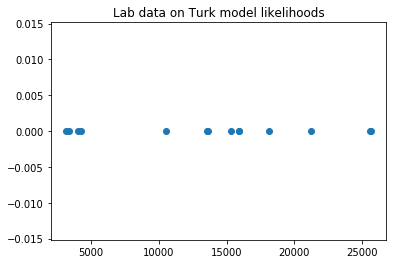

In [44]:
lab_data_turk_model = model_score_list(turk_model, m_lab, lab_lengths)  # Try lab data on turk model

#plt.scatter(turk_data_lab_model,turk_data_lab_model)
plt.scatter( lab_data_turk_model, np.zeros((len(lab_data_turk_model),1)) )
plt.title('Lab data on Turk model likelihoods')

In [45]:
model_score_list(lab_model, m_lab, lab_lengths)    # Try lab data on lab model
# This cant be correct as surely it should remember its own training data.

[11504.840622670985,
 11965.638879104456,
 11967.170294459382,
 3179.0950600207734,
 3068.238735053815,
 14385.884354358685,
 6266.911882679236,
 -315.113172173358,
 13686.923082629683,
 -532.5809136900396,
 19323.85973214222,
 17532.273607143332,
 8532.491806466442,
 10210.68964848702]

Text(0.5, 1.0, 'Lab data on Lab model likelihoods')

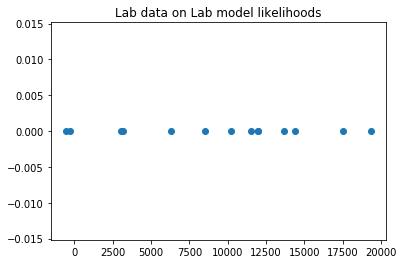

In [46]:
lab_data_lab_model = model_score_list(lab_model, m_lab, lab_lengths)  # Try lab data on lab model

#plt.scatter(turk_data_lab_model,turk_data_lab_model)
plt.scatter( lab_data_lab_model, np.zeros((len(lab_data_lab_model),1)) )
plt.title('Lab data on Lab model likelihoods')

In [47]:
model_score_list(turk_model, m_turk, turk_lengths)  # Try turk data on turk model

[2467.7299210960146,
 4227.312726639802,
 6973.295306708843,
 5598.289015332112,
 1241.206092321523,
 1979.8751397478989,
 2947.9594527596364,
 5634.944796569134,
 17405.715319972234,
 6795.669997464934,
 4572.572130845531,
 14880.749628290096,
 2808.6309679508527,
 6368.8940902209815,
 5237.782475579844,
 12539.475575257624,
 2723.859662872712,
 6061.811134108482,
 3788.796772445519,
 3248.0006500978157,
 10500.376151874634,
 19460.634441815844,
 22594.780301663628,
 11376.405823630912,
 2978.6915849363563,
 20133.15958809692,
 4124.410866933782,
 14179.664272810882,
 11200.223845519782,
 21658.547433240376,
 6430.203283895057,
 4215.123108148048,
 3704.5740878769557,
 26512.400417821995,
 2757.717447113265,
 3423.8245601735653,
 8470.750258239525,
 23445.46040331173,
 6219.480183837141,
 18741.66820333041,
 35715.29486327501,
 10184.00934480263,
 12776.60962564761,
 7361.321942492422,
 19892.446183497443,
 9359.798396431815,
 1822.2902651091697,
 19831.55681046975,
 10952.11955030450

Text(0.5, 1.0, 'Turk data on Turk model likelihoods')

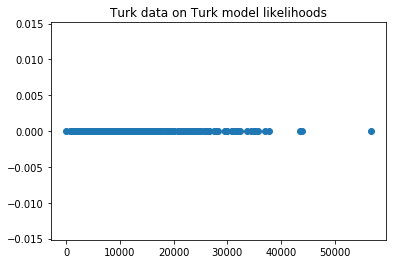

In [48]:
turk_data_turk_model = model_score_list(turk_model, m_turk, turk_lengths)  # Try turk data on turk model

#plt.scatter(turk_data_lab_model,turk_data_lab_model)
plt.scatter( turk_data_turk_model, np.zeros((len(turk_data_turk_model),1)) )
plt.title('Turk data on Turk model likelihoods')

In [49]:
model_score_list(lab_model, m_turk, turk_lengths)  # Try turk data on lab model

# There is a big variation in this data, maybe plot descriptions of list like s.d., mean, ave, etc

[1868.9064738218979,
 3180.684518482108,
 3661.7013145278092,
 4177.4515275017675,
 896.4816163712159,
 -1451.2059983137376,
 1510.9293737235257,
 3540.1244817889988,
 12330.06604422303,
 1526.4313919233857,
 3539.383430889703,
 10322.698822696875,
 1415.4498952313475,
 1900.5642106589755,
 3998.3074160295164,
 6410.910159953187,
 -882.6221044515102,
 1664.5189985689142,
 2866.3968248377764,
 2424.3454367391632,
 7128.488996188435,
 13834.594914140514,
 12707.908483141131,
 6464.849838573043,
 2103.1363450351255,
 13710.344687532157,
 2822.6353799345957,
 8980.191476135296,
 7637.432201915627,
 14490.894325634008,
 1696.0736049859506,
 3224.2044720649405,
 1132.6246756563705,
 19209.59121566837,
 2152.387779841897,
 -320.2000401357039,
 6475.174088955594,
 16516.95902103265,
 4647.634498998305,
 13351.74324291694,
 20520.888674998125,
 3244.2325027000356,
 8100.028056684618,
 5082.345872538986,
 14154.103443507116,
 6653.763287557338,
 1406.7952851709429,
 14336.192984883523,
 7794.989

Text(0.5, 1.0, 'Turk data on Lab model likelihoods')

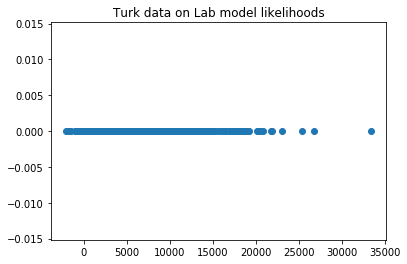

In [50]:
turk_data_lab_model = model_score_list(lab_model, m_turk, turk_lengths)  # Try turk data on lab model

#plt.scatter(turk_data_lab_model,turk_data_lab_model)
plt.scatter( turk_data_lab_model, np.zeros((len(turk_data_lab_model),1)) )
plt.title('Turk data on Lab model likelihoods')

# Mabye we can say that any items above 20,000 belong so well to the lab class we can reclassify
# For turk data on turk model could say any negative values are in the wrong class and should be reclassified to online data.

# AMAZING IDEA

hmmlearn has the function .SAMPLE(n). This Generates random samples from the model.

With some effort could potentially use this to generate new samples for lab data!

In [173]:
# Lab Data

from statistics import mean
ave_lab_length = int(np.round(mean(lab_lengths),0) ) # Ave length to nearest whole number
print( ave_lab_length )
print( lab_lengths )

# Now sample points 1999 times to get a created lab data distributions.
# np.round(np.array(turk_model.sample(10)[0]).reshape(-1),2)

created_data = []

# Create 10 data samples
for i in range(5):
    created_data.append( np.round(lab_model.sample(ave_lab_length)[0],0) )


1999
[2267, 2341, 2341, 646, 597, 3116, 1531, 490, 2666, 469, 3754, 3754, 2005, 2005]


In [154]:
print(created_data)

[array([[ 1.],
       [ 0.],
       [-0.],
       ...,
       [ 2.],
       [ 2.],
       [ 2.]]), array([[0.],
       [2.],
       [2.],
       ...,
       [3.],
       [3.],
       [3.]]), array([[-0.],
       [ 0.],
       [ 0.],
       ...,
       [ 2.],
       [ 2.],
       [ 2.]]), array([[0.],
       [0.],
       [0.],
       ...,
       [5.],
       [5.],
       [5.]]), array([[1.],
       [1.],
       [1.],
       ...,
       [5.],
       [5.],
       [5.]])]


In [158]:
created_data2 = np.array(created_data)
created_data2[0]

array([[ 1.],
       [ 0.],
       [-0.],
       ...,
       [ 2.],
       [ 2.],
       [ 2.]])

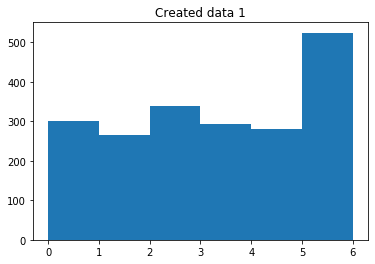

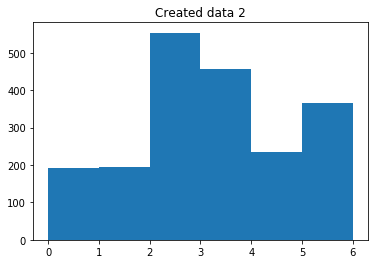

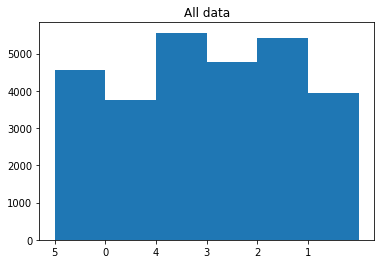

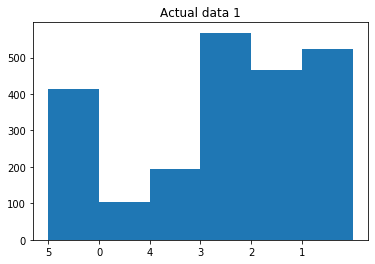

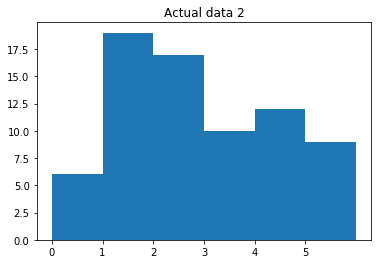

In [171]:
plt.hist(createditem1, bins=[0,1,2,3,4,5,6])
plt.title('Created data 1')
plt.show()
plt.hist(createditem2, bins=[0,1,2,3,4,5,6])
plt.title('Created data 2')
plt.show()


plt.hist(m_lab, bins=[0,1,2,3,4,5,6])
plt.title('All data')
plt.show()

plt.hist(m_lab[:lab_lengths[0]], bins=[0,1,2,3,4,5,6])
plt.title('Actual data 1')
plt.show()
plt.hist(m_lab[lab_lengths[0]+1:lab_lengths[1]], bins=[0,1,2,3,4,5,6])
plt.title('Actual data 2')
plt.show()

In [179]:
# Turk created Data
ave_turk_length = int(np.round(mean(turk_lengths),0) ) # Ave length to nearest whole number
print( ave_turk_length )
print( turk_lengths )

# Now sample points 1999 times to get a created turk data distributions.
# np.round(np.array(turk_model.sample(10)[0]).reshape(-1),2)

turk_created_data = []

# Create 300 data samples
for i in range(300):
    turk_created_data.append( np.round(turk_model.sample(ave_turk_length)[0],0) )



1677
[365, 608, 1005, 801, 178, 292, 430, 812, 2545, 1009, 657, 2162, 406, 918, 757, 1821, 408, 874, 550, 470, 1510, 2851, 3275, 1640, 436, 2935, 613, 2056, 1653, 3158, 944, 610, 535, 3866, 398, 490, 1218, 3421, 905, 2747, 5202, 1466, 1876, 1086, 2912, 1374, 261, 2893, 1605, 1695, 4019, 1346, 505, 2237, 1313, 1254, 4340, 1089, 832, 3654, 3242, 750, 555, 348, 2449, 437, 896, 517, 985, 1248, 304, 1483, 1361, 757, 1015, 1942, 1267, 1372, 466, 474, 2285, 3127, 1654, 776, 3084, 1888, 249, 1261, 1367, 1116, 2887, 916, 1276, 1258, 491, 2059, 1137, 2890, 652, 1168, 2844, 3778, 1157, 945, 4892, 596, 3244, 1727, 1114, 617, 1021, 3594, 675, 1063, 2211, 531, 524, 1588, 3551, 854, 1098, 2923, 1471, 4488, 1968, 3552, 5081, 2055, 1741, 1228, 693, 1594, 1478, 1153, 1879, 614, 914, 477, 166, 211, 1895, 727, 1063, 2284, 757, 652, 3227, 1570, 2722, 6363, 2464, 1368, 3246, 753, 1085, 952, 1436, 1744, 1157, 1048, 6389, 2140, 1780, 655, 941, 371, 181, 2884, 835, 487, 1234, 1598, 745, 2195, 2085, 3744, 1878,

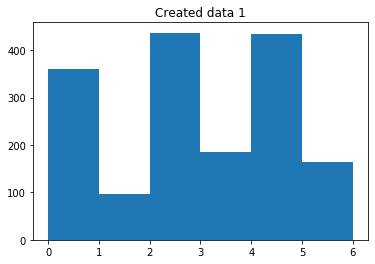

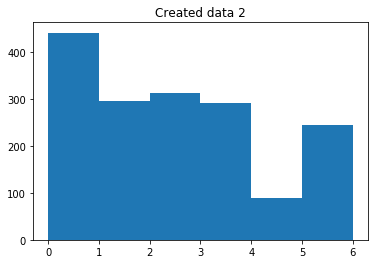

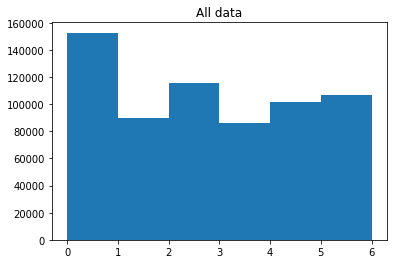

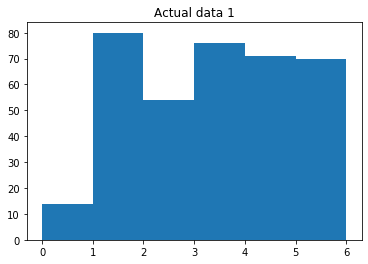

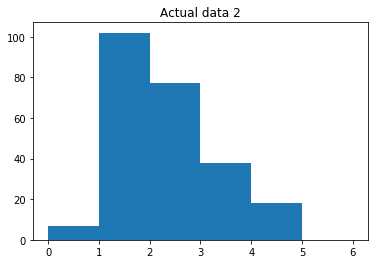

In [182]:

# Visualize created Data.

plt.hist(turk_created_data[0], bins=[0,1,2,3,4,5,6])
plt.title('Created data 1')
plt.show()
plt.hist(turk_created_data[1], bins=[0,1,2,3,4,5,6])
plt.title('Created data 2')
plt.show()


plt.hist(m_turk, bins=[0,1,2,3,4,5,6])
plt.title('All data')
plt.show()

plt.hist(m_turk[:turk_lengths[0]], bins=[0,1,2,3,4,5,6])
plt.title('Actual data 1')
plt.show()
plt.hist(m_turk[turk_lengths[0]+1:turk_lengths[1]], bins=[0,1,2,3,4,5,6])
plt.title('Actual data 2')
plt.show()

In [199]:
df_turk_created = pd.DataFrame.from_records( turk_created_data )
#df_turk_created.replace([0.0],'html')
df_turk_created = df_turk_created.replace(0,'html')
df_turk_created = df_turk_created.replace(1,'alloc-slider-1')
df_turk_created = df_turk_created.replace(2,'alloc-slider-2')
df_turk_created = df_turk_created.replace(3,'alloc-slider-3')
df_turk_created = df_turk_created.replace(4,'alloc-slider-4')
df_turk_created = df_turk_created.replace(5,'alloc-slider-5')

In [202]:
df_turk_created

,0,1,2,3,4,5,6,7,8,9,...,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676
0,html,html,html,html,html,html,html,html,html,html,...,alloc-slider-3,alloc-slider-3,alloc-slider-3,alloc-slider-3,alloc-slider-3,alloc-slider-3,alloc-slider-3,alloc-slider-3,alloc-slider-3,alloc-slider-3
1,html,html,alloc-slider-1,alloc-slider-1,alloc-slider-1,alloc-slider-1,alloc-slider-1,alloc-slider-1,alloc-slider-1,alloc-slider-1,...,alloc-slider-4,alloc-slider-4,alloc-slider-4,alloc-slider-4,alloc-slider-4,alloc-slider-4,alloc-slider-4,alloc-slider-4,alloc-slider-4,alloc-slider-4
2,html,html,html,html,html,html,html,alloc-slider-1,alloc-slider-1,alloc-slider-1,...,alloc-slider-2,alloc-slider-2,alloc-slider-2,alloc-slider-2,alloc-slider-2,alloc-slider-2,alloc-slider-2,alloc-slider-2,alloc-slider-2,alloc-slider-2
3,html,html,html,html,html,html,html,html,html,html,...,alloc-slider-4,alloc-slider-4,alloc-slider-4,alloc-slider-4,alloc-slider-5,alloc-slider-5,alloc-slider-5,alloc-slider-5,alloc-slider-5,alloc-slider-5
4,alloc-slider-1,alloc-slider-1,alloc-slider-1,alloc-slider-1,alloc-slider-1,alloc-slider-1,alloc-slider-2,alloc-slider-2,alloc-slider-2,alloc-slider-2,...,alloc-slider-3,html,html,html,html,html,alloc-slider-3,alloc-slider-3,alloc-slider-3,alloc-slider-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,alloc-slider-1,alloc-slider-1,alloc-slider-1,alloc-slider-1,alloc-slider-1,alloc-slider-1,alloc-slider-1,alloc-slider-1,alloc-slider-1,alloc-slider-1,...,alloc-slider-1,alloc-slider-5,alloc-slider-5,alloc-slider-5,alloc-slider-5,alloc-slider-5,alloc-slider-5,alloc-slider-5,alloc-slider-5,alloc-slider-5
296,html,html,html,html,html,html,html,alloc-slider-3,alloc-slider-3,alloc-slider-3,...,alloc-slider-1,alloc-slider-1,alloc-slider-1,alloc-slider-1,alloc-slider-1,alloc-slider-1,alloc-slider-1,alloc-slider-1,alloc-slider-1,alloc-slider-1
297,alloc-slider-5,alloc-slider-5,alloc-slider-5,alloc-slider-5,alloc-slider-5,alloc-slider-5,alloc-slider-5,alloc-slider-5,alloc-slider-5,alloc-slider-5,...,alloc-slider-2,alloc-slider-2,alloc-slider-2,alloc-slider-2,alloc-slider-2,alloc-slider-2,alloc-slider-2,alloc-slider-2,alloc-slider-2,alloc-slider-2
298,alloc-slider-4,alloc-slider-4,alloc-slider-4,alloc-slider-4,alloc-slider-4,alloc-slider-4,alloc-slider-4,alloc-slider-4,alloc-slider-4,alloc-slider-4,...,alloc-slider-5,alloc-slider-5,alloc-slider-5,alloc-slider-5,alloc-slider-5,alloc-slider-5,html,html,html,html


In [291]:
created_turk_array = np.array(turk_created_data)
df_turk_created = pd.DataFrame(created_turk_array.flatten())

# Need to create a list of ID's that our generated samples can use.
gen_ids = []
for i in range(300): # 300 new samples created
    gen_ids.append([i]*ave_turk_length)
gen_ids = np.array(gen_ids).flatten()

df_turk_created['turkId'] = gen_ids
df_turk_created.columns = ['target', 'turkId']


df_turk_created['target'] = df_turk_created['target'].replace(0,'html')
df_turk_created['target'] = df_turk_created['target'].replace(1,'alloc-slider-1')
df_turk_created['target'] = df_turk_created['target'].replace(2,'alloc-slider-2')
df_turk_created['target'] = df_turk_created['target'].replace(3,'alloc-slider-3')
df_turk_created['target'] = df_turk_created['target'].replace(4,'alloc-slider-4')
df_turk_created['target'] = df_turk_created['target'].replace(5,'alloc-slider-5')
df_turk_created

,target,turkId
0,html,0
1,html,0
2,html,0
3,html,0
4,html,0
...,...,...
503095,alloc-slider-3,299
503096,alloc-slider-3,299
503097,alloc-slider-3,299
503098,alloc-slider-3,299


In [293]:
# Save as csv and explore in tableau
df_turk_created.to_csv('created-turk-data.csv')

In [284]:
test_df['turkId'] = gen_ids
test_df

,0,turkId
0,0.0,0
1,0.0,0
2,-0.0,0
3,0.0,0
4,-0.0,0
...,...,...
503095,3.0,299
503096,3.0,299
503097,3.0,299
503098,3.0,299


In [ ]:
# Save created data as a pandas dataframe, then rename numbers to their string representations, 

# Old Idea

Compare the counts of targets of one use to other users, and mean of users.
This would give us a value of how "strongly" a user belongs to their group.
Then see if the user may belong more to another group?

In [51]:
#TODO: https://medium.com/@a.ydobon/justforfunpython-n-gram-to-quantify-similarity-between-sentences-2d61e68a478c
# Use this method to compare one users targets with the rest of their class to get a similarity.
# Then can get the average similarity compared to the group of each target.
# Then compare similarity to other group e.g. how similar is this turk to a lab person.
# If any turk matches lab more then we boldly assume it belongs in the wrong class.

# This funciton works perfectly, its the other function that doesnt work properly lol.
def lists_similarity(list_a, list_b):
    # Calculates siilarity of list_a to list_b
    # Given 2 lists of ngrams, return how 'similar' lists are
    # Similarity is number of matching items / length of list a
    
    similar_count = 0
    common=[]

    for item_a in list_a:
        for item_b in list_b:
            if item_a == item_b:
                #print('MATCH')
                similar_count += 1
                common.append(item_a)


    #print('similar_count', similar_count)
    #print('len(list_a)', len(list_a))
    #print('len(list_b)', len(list_b))
    similarity = similar_count/len(list_a)
    return similarity#,common
    

In [52]:
# Look into similarity matrixes Tom seems to think theyre the same thing.

def compare_all(dataframe, n):
    IDs = dataframe['turkId'].unique()

    # First get a list of all the ngrams for each user in the dataframe
    users_ngrams_list = []

    for ID in IDs:
        targets = dataframe[ dataframe['turkId'] == ID ] ['target'].to_numpy()

        ngrams_generator = nltk.ngrams(targets, n)  # creates ngram generator, can be used to find ngrams
        ngrams_list = list(ngrams_generator)        # generator to list
        
        users_ngrams_list.append(ngrams_list)

    #users_ngrams_list # this is a list of lists. index 0 has a list of ngrams from the first user ID.


    # FIrst enumerates, a and b are essesnally a list of the unique users that we go through.
    # After that loop we index into the list, which contains a list of the ngrams of the user with that index
    # e.g. index 0 stores the ngrams about the first user at IDs[0]

    resutls = []    # results should end up being same length as num of IDs

    for index_a, ngrams_list_a in enumerate(users_ngrams_list):
        print(f'ID:{index_a} out of {len(users_ngrams_list)}')

        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time =", current_time)

        total_similarity = 0
        for index_b, ngrams_list_b in enumerate(users_ngrams_list):
            # compare list index_a's ngrams with list index_b's

            # we dont want to compare a list to itself for similarity
            if index_a != index_b:
                total_similarity += lists_similarity(ngrams_list_a, ngrams_list_b)

        #print('total_similarity', total_similarity)
        similarity_average = total_similarity/len(IDs)
        #print(f'{index_a} average similarity : {similarity_average}')
        resutls.append(similarity_average)

        #print('similarity_average', similarity_average)

    return pd.DataFrame( {'ID': IDs, 'Similarity': resutls} )

#lab_sim = compare_all(df_lab, 2)
#turk_sim = compare_all(df_turk, 2) # start time 15:36

In [53]:
#turk_sim = compare_all(df_turk, 2) # start time 20:37

In [54]:
lab_sim

NameError: name 'lab_sim' is not defined

In [0]:
turk_sim.to_csv('turk_sim.csv') # Save as this took AGES to run
turk_sim.plot(kind='bar')